In [2]:
import torch
import torch.nn as nn

In [3]:
class Self_Attention(nn.Module):
    def __init__(self, embed_size, heads):
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        self.values = nn.Linear(self.head_dim, self.head_dim, bias = False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias = False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias = False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        answer = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape : (N, query_len, heads, head_dim)
        # keys shape : (N, key_len, heads, head_dim)
        # answer shape : (N, heads, query_len, key_len)

        if mask is not None:
            answer = answer.masked_fill(mask == 0, float("-1e20"))
        
        attention = torch.softmax(answer / (self.embed_size ** (1/2)), dim = 3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values])
        out = out.reshape(N, query_len, self.heads * self.head_dim)
        # attention shape : (N, heads, query_len, key_len)
        # values shape : (N, value_len, heads, head_dim)
        # out shape : (N, query_len, head, head_dim) and the flatten last 2 dimensions
        
        out = self.fc_out(out)
        return out

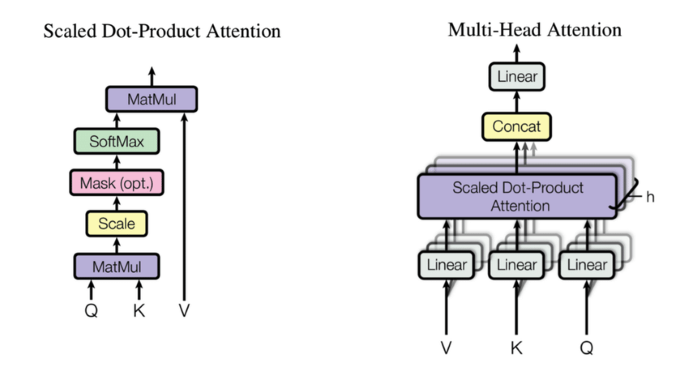

In [4]:
class Transformer_Block(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(Transformer_Block, self).__init()
        self.attention = Self_Attention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size), # forward_expansion is 4 which is used in original paper
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )
        self.dropout = nn.Dropout(dropout)
    
    def forward(self,value, key, query, mask):
        attention = self.attention(value, key, query, mask)
        norm1 = self.norm1(attention + query)
        x = self.dropout(norm1) 
        forward = self.feed_forward(x)
        norm2 = self.norm2(forward + x)
        out = self.dropout(norm2)
        return out

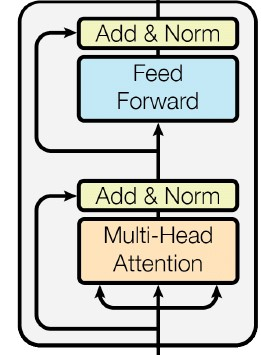

In [ ]:
class Encoder(nn.Module):
    def __init__(
            self,
            src_vocab_size,
            embed_size, 
            num_layers,
            heads,
            forward_expansion,
            dropout,
            max_length,
            device,
    ):
        super(Encoder, self).__init()
        self.embed_size = embed_size
        self.word_embeddings = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                Transformer_Block(
                    embed_size,
                    heads,
                    dropout = dropout,
                    forward_expansion = forward_expansion
                )
            ]
        )
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask):


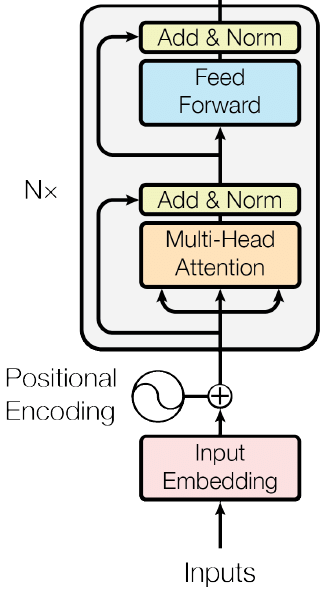